In [25]:
# importing required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [26]:
col_names = ['AAGE', 'ACLSWKR', 'ADTIND', 'ADTOCC', 'AHGA', 'AHRSPAY', 'AHSCOL', 'AMARITL', 'AMJIND', 'AMJOCC',
             'ARACE', 'AREORGN', 'ASEX', 'AUNMEM', 'AUNTYPE', 'AWKSTAT', 'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'FILESTAT',
             'GRINREG', 'GRINST', 'HHDFMX', 'HHDREL', 'MARSUPWT', 'MIGMTR1', 'MIGMTR3', 'MIGMTR4', 'MIGSAME', 'MIGSUN',
             'NOEMP', 'PARENT', 'PEFNTVTY', 'PEMNTVTY', 'PENATVTY', 'PRCITSHP', 'SEOTR', 'VETQVA', 'VETYN', 'WKSWORK',
             'YEAR', 'TARGET']

census_income_train = pd.read_csv('census_income_train.csv', index_col=False, names=col_names, header=None, skipinitialspace=True)
census_income_test = pd.read_csv('census_income_test.csv', index_col=False, names=col_names, header=None, skipinitialspace=True)

# combining the training and test data
clean_data = pd.concat([census_income_train, census_income_test], ignore_index=True)

# __Preprocessed Data__

In [27]:
# data cleaning and preprocessing
def convert_missing_values(df):
    identifiers = ['?', 'NA', 'nan', 'Do not know', 'Not in universe', 'Not identifiable',
                   'Not in universe or children', 'Not in universe under 1 year old']
    df.replace(to_replace=identifiers, value=np.NaN, inplace=True)

def cols_to_int(df):
    cols = ['AAGE', 'AHRSPAY', 'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'NOEMP', 'WKSWORK']
    df[cols] = df[cols].astype('int')

def cols_to_category(df):
    categorical_cols = ategorical_cols = ['ACLSWKR', 'ADTIND', 'ADTOCC', 'AHGA', 'AHSCOL', 'AMARITL', 'AMJIND', 'AMJOCC', 'ARACE', 'AREORGN',
                        'ASEX', 'AUNMEM', 'AUNTYPE', 'AWKSTAT', 'FILESTAT', 'GRINREG', 'GRINST', 'HHDFMX', 'HHDREL', 'MIGMTR1',
                        'MIGMTR3', 'MIGMTR4', 'MIGSAME', 'MIGSUN', 'PARENT', 'PEFNTVTY', 'PEMNTVTY', 'PENATVTY', 'PRCITSHP', 'SEOTR',
                        'VETQVA', 'VETYN', 'YEAR', 'TARGET']
    
    df[categorical_cols] = df[categorical_cols].astype('category')

def preprocess_data(dataframe_list):
    for dataframe in dataframe_list:
        convert_missing_values(dataframe)
        cols_to_int(dataframe)
        cols_to_category(dataframe)


preprocess_data([clean_data])

# encoding the target variable
clean_data['TARGET'] = clean_data['TARGET'].apply(lambda x: 1 if x == '50000+.' else 0)

# splitting into target and feature data
X = clean_data.drop('TARGET', axis=1)
y = clean_data['TARGET']

categorical_cols = ['ACLSWKR', 'ADTIND', 'ADTOCC', 'AHGA', 'AHSCOL', 'AMARITL', 'AMJIND', 'AMJOCC', 'ARACE', 'AREORGN',
                    'ASEX', 'AUNMEM', 'AUNTYPE', 'AWKSTAT', 'FILESTAT', 'GRINREG', 'GRINST', 'HHDFMX', 'HHDREL', 'MIGMTR1',
                    'MIGMTR3', 'MIGMTR4', 'MIGSAME', 'MIGSUN', 'PARENT', 'PEFNTVTY', 'PEMNTVTY', 'PENATVTY', 'PRCITSHP', 'SEOTR',
                    'VETQVA', 'VETYN', 'YEAR']

# encoding cat features
label_encoder = LabelEncoder()
for column in categorical_cols:
    if column in X.columns:
        X[column] = label_encoder.fit_transform(X[column])

X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


# splitting into testing and training sets
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# scaling the numeric factors
numerical_cols = ['AAGE', 'AHRSPAY', 'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'NOEMP', 'WKSWORK']
scaler = StandardScaler()
X_train_encoded[numerical_cols] = scaler.fit_transform(X_train_encoded[numerical_cols])
X_test_encoded[numerical_cols] = scaler.transform(X_test_encoded[numerical_cols])

# __Feature Extraction__

In [28]:
# Separate features from the target variable
X_features = clean_data.drop('TARGET', axis=1)

# Display the first few rows of the features
print(X_features.head())

   AAGE                         ACLSWKR ADTIND ADTOCC  \
0    73                             NaN      0      0   
1    58  Self-employed-not incorporated      4     34   
2    18                             NaN      0      0   
3     9                             NaN      0      0   
4    10                             NaN      0      0   

                         AHGA  AHRSPAY       AHSCOL        AMARITL  \
0        High school graduate        0          NaN        Widowed   
1  Some college but no degree        0          NaN       Divorced   
2                  10th grade        0  High school  Never married   
3                    Children        0          NaN  Never married   
4                    Children        0          NaN  Never married   

         AMJIND                               AMJOCC  ...  \
0           NaN                                  NaN  ...   
1  Construction  Precision production craft & repair  ...   
2           NaN                                  NaN 

# __Principal Component Analysis__

In [29]:
# preprocessing cat varibles
X_encoded = pd.get_dummies(X_features, columns=categorical_cols, drop_first=True)

# standarizing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# performing PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# creating df for principal components
principal_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

print(principal_df.head())

   Principal Component 1  Principal Component 2
0              -1.163380               0.181014
1               1.820251               0.675659
2              -2.347926               7.477202
3              -4.705616              -1.703735
4              -4.703293              -1.675874


In [30]:
# building clusters with principal components using K-means
num_clusters = 3 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(principal_components)

# adding in cluster label
principal_df['Cluster'] = clusters

# PCA with cluster labels
print(principal_df.head())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


   Principal Component 1  Principal Component 2  Cluster
0              -1.163380               0.181014        1
1               1.820251               0.675659        1
2              -2.347926               7.477202        2
3              -4.705616              -1.703735        0
4              -4.703293              -1.675874        0


__Elbow Plot__

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

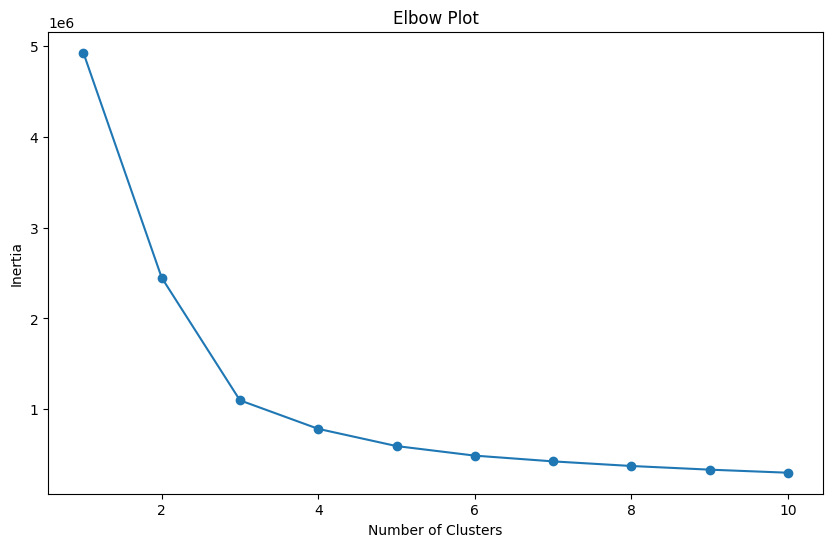

In [31]:
# empty list of vals
inertia_values = []

# optimal # of clusters
for num_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(principal_components)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot')

plt.show()

In [32]:
optimal_num_clusters = 3

# K-Menas with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)

# fitting k-means to data
cluster_labels = kmeans.fit_predict(principal_components)

# adding cluster label
principal_df['Cluster'] = cluster_labels

print(principal_df.head())


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


   Principal Component 1  Principal Component 2  Cluster
0              -1.163380               0.181014        1
1               1.820251               0.675659        1
2              -2.347926               7.477202        2
3              -4.705616              -1.703735        0
4              -4.703293              -1.675874        0


In [33]:
optimal_num_clusters = 3
kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)

# fitting K-means
kmeans.fit(X_train_encoded)

# predicitng clustering on training and test sets
train_cluster_labels = kmeans.predict(X_train_encoded)
test_cluster_labels = kmeans.predict(X_test_encoded)

# applying PCA to feature data
pca = PCA(n_components=2)
principal_components_train = pca.fit_transform(X_train_encoded)
principal_components_test = pca.transform(X_test_encoded)

# dfs for principal components
principal_df_train = pd.DataFrame(data=principal_components_train, columns=['Principal Component 1', 'Principal Component 2'])
principal_df_test = pd.DataFrame(data=principal_components_test, columns=['Principal Component 1', 'Principal Component 2'])

# adding cluster labels
principal_df_train['Cluster'] = train_cluster_labels
principal_df_test['Cluster'] = test_cluster_labels

print("Principal DataFrame (Training Set):")
print(principal_df_train.head())

print("\nPrincipal DataFrame (Test Set):")
print(principal_df_test.head())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Principal DataFrame (Training Set):
   Principal Component 1  Principal Component 2  Cluster
0            2018.561788               0.905343        1
1             256.681416              -2.718037        0
2           -1321.618428              -2.295905        2
3            -739.148144               1.644525        2
4            -347.608200               1.238649        2

Principal DataFrame (Test Set):
   Principal Component 1  Principal Component 2  Cluster
0             556.501494              -0.381893        0
1             163.771626              -0.636689        0
2           -1203.738580              -2.594252        2
3              56.311590              -1.210981        0
4            1228.491495              -2.868369        1


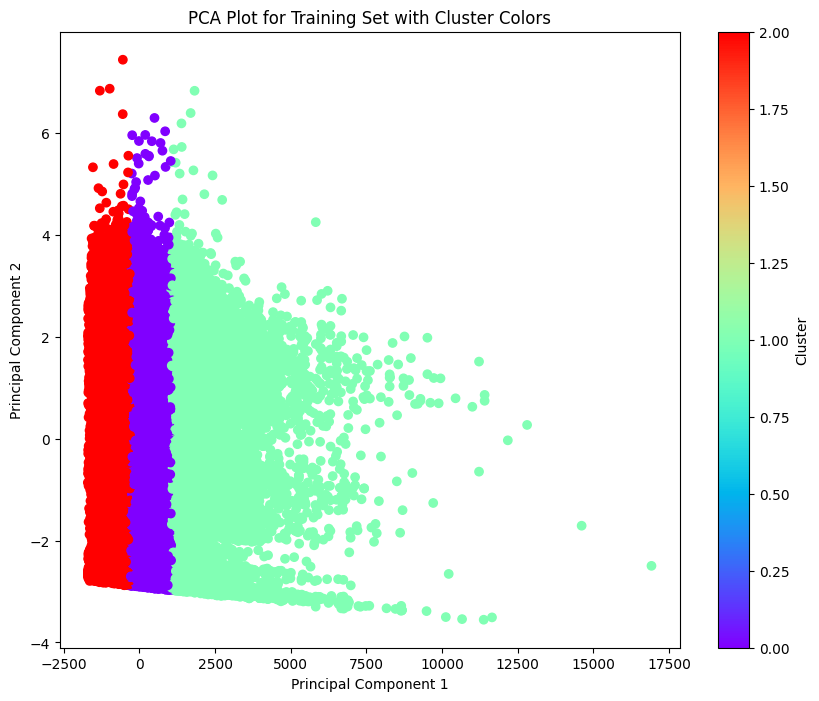

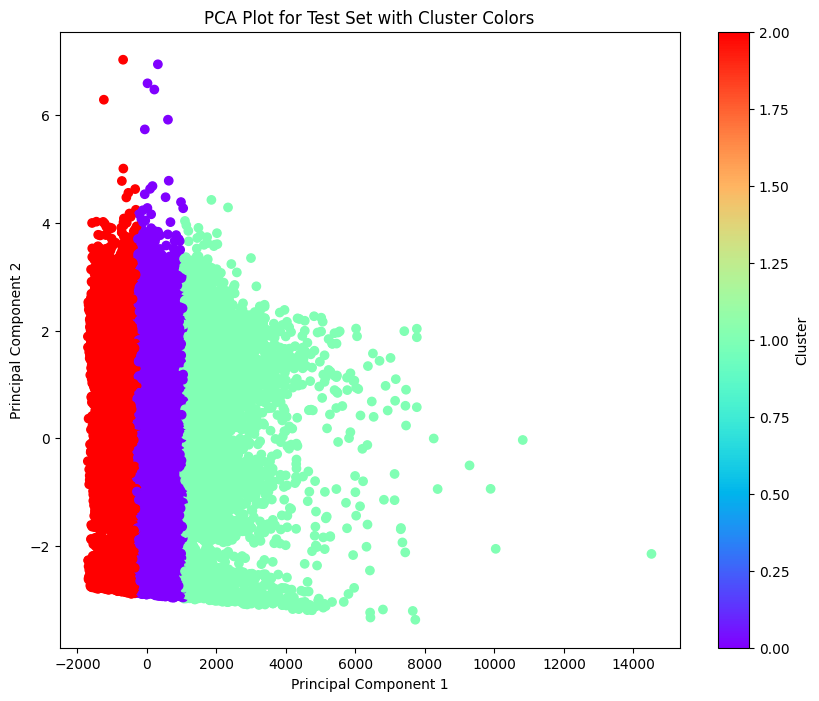

In [34]:
# scatter for training set
plt.figure(figsize=(10, 8))
plt.scatter(principal_df_train['Principal Component 1'], principal_df_train['Principal Component 2'], c=train_cluster_labels, cmap='rainbow')
plt.title('PCA Plot for Training Set with Cluster Colors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# scatter for test set
plt.figure(figsize=(10, 8))
plt.scatter(principal_df_test['Principal Component 1'], principal_df_test['Principal Component 2'], c=test_cluster_labels, cmap='rainbow')
plt.title('PCA Plot for Test Set with Cluster Colors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

__The clusters represent the income prediciton against the target variable with values <50 and those >=50K.__

In [35]:
# K-means with 2 clusters
kmeans_2_clusters = KMeans(n_clusters=2, random_state=42)
cluster_predictions_train = kmeans_2_clusters.fit_predict(principal_components_train)

# accuracry of predicitons for training set
cluster_accuracy_train = accuracy_score(y_train, cluster_predictions_train)

# cluster predictions for test set
cluster_predictions_test = kmeans_2_clusters.predict(principal_components_test)

# calculating accuracy
cluster_accuracy_test = accuracy_score(y_test, cluster_predictions_test)

print(f"Accuracy of Cluster Predictions for Training Set: {cluster_accuracy_train:.2f}")
print(f"Accuracy of Cluster Predictions for Test Set: {cluster_accuracy_test:.2f}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Accuracy of Cluster Predictions for Training Set: 0.28
Accuracy of Cluster Predictions for Test Set: 0.28


__Using cluster predictions to represent income levels could offer some exploratory insights, but it might not provide a reliable substitute for the actual income labels. Clustering is primarily a technique for grouping similar instances, while income classification involves predicting a specific label based on the available features. If one is seeking accurate income prediction, it is generally better to use traditional classification models with appropriate evaluation metrics would likely yield more reliable results.__